<a href="https://colab.research.google.com/github/evanwilliamsconsulting/Kaggle_Feedback_Prize/blob/main/Kaggle_Student_Essays_Example.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# https://towardsdatascience.com/multi-class-text-classification-with-doc2vec-logistic-regression-9da9947b43f4

In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm
tqdm.pandas(desc="progress-bar")
from gensim.models import Doc2Vec
from sklearn import utils
from sklearn.model_selection import train_test_split
import gensim
from sklearn.linear_model import LogisticRegression
from gensim.models.doc2vec import TaggedDocument
import re
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
%matplotlib inline
from pathlib import Path
import pandas as pd
import numpy as np

In [3]:
import os

In [4]:
from os import listdir

In [5]:
# https://stackoverflow.com/questions/48376580/google-colab-how-to-read-data-from-my-google-drive
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


In [6]:
DATA = "/content/drive/MyDrive"

In [7]:
corpus_directory = os.path.join(DATA,'Kaggle','data','train')

In [8]:
root_directory = os.path.join(DATA,'Kaggle')

In [9]:
datasets_directory = os.path.join(DATA,'Kaggle','datasets')

In [10]:
train_filename = "train.csv"

In [11]:
train_filepath = os.path.join(root_directory,train_filename)

In [12]:
essay_files = listdir(corpus_directory)

In [13]:
len(essay_files)

15594

In [14]:
essay_filename = essay_files[664]

In [15]:
essay_filepath = os.path.join(corpus_directory,essay_filename)

In [16]:
essay_text = pd.read_table(essay_filepath,header=0,engine='python',error_bad_lines=False)

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version.


  exec(code_obj, self.user_global_ns, self.user_ns)
Skipping line 17: unexpected end of data


In [ ]:
# to bring in the tags

In [17]:
train_df = pd.read_csv(train_filepath,header=0,engine='python')

In [18]:
train_df.head()

,id,discourse_id,discourse_start,discourse_end,discourse_text,discourse_type,discourse_type_num,predictionstring
0,423A1CA112E2,1.622628e+12,8.0,229.0,Modern humans today are always on their phone....,Lead,Lead 1,1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 1...
1,423A1CA112E2,1.622628e+12,230.0,312.0,They are some really bad consequences when stu...,Position,Position 1,45 46 47 48 49 50 51 52 53 54 55 56 57 58 59
2,423A1CA112E2,1.622628e+12,313.0,401.0,Some certain areas in the United States ban ph...,Evidence,Evidence 1,60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75
3,423A1CA112E2,1.622628e+12,402.0,758.0,"When people have phones, they know about certa...",Evidence,Evidence 2,76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 9...
4,423A1CA112E2,1.622628e+12,759.0,886.0,Driving is one of the way how to get around. P...,Claim,Claim 1,139 140 141 142 143 144 145 146 147 148 149 15...


In [19]:
print(len(train_df))

144293


In [59]:
def retrieveWordage(essay_id):
  essay_filename = essay_id + ".txt"
  essay_filepath = os.path.join(corpus_directory,essay_filename)
  essay_text = pd.read_table(essay_filepath,header=0,engine='python',error_bad_lines=False)
  essay_text.columns = ['narrative']
  return essay_text

In [60]:
wordage_test = retrieveWordage("0027FC00C35B")

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version.


  """Entry point for launching an IPython kernel.
Skipping line 27: '	' expected after '"'


In [21]:
def cleanText2(item):
  item2 = ""
  for ch in item:
      if ch == ' ' or (ch >= 'a' and ch <= 'z') or (ch >= 'A' and ch <= 'Z') or (ch >= '0' and ch <= '9'):
          if ch >= 'A' and ch <= 'Z':
              item2 += ch.lower()
          else:
              item2 += ch
  return item2

In [22]:
def retrieveEssay(essay_id):
  essay_text = retrieveWordage(essay_id)
  essay_count = len(essay_text)
  essay = ""
  for i in range(0,essay_count-1):
      essay += cleanText2(essay_text.iloc[i,0])
  return essay

In [23]:
def retrieveRawEssay(essay_id):
  essay_text = retrieveWordage(essay_id)
  essay_count = len(essay_text)
  essay = ""
  for i in range(0,essay_count-1):
      item = essay_text.iloc[i,0]
      essay += item
  return essay

In [24]:
essay_test = retrieveEssay("423A1CA112E2")

In [25]:
from tensorflow.data import Dataset

In [26]:
from tensorflow.data import TextLineDataset

In [27]:
def retrieveDataset(essay_id):
  essay_array = []
  essay_text = retrieveWordage(essay_id)
  essay_count = len(essay_text)
  #essay = ""
  for i in range(0,essay_count-1):
      essay_array.append(cleanText2(essay_text.iloc[i,0]))
  #essay = essay_text.iloc[0,0]
  dataset = Dataset.from_tensor_slices(essay_array)
  return dataset

In [28]:
text_dataset = retrieveDataset("423A1CA112E2")

In [29]:
print(text_dataset)

<TensorSliceDataset element_spec=TensorSpec(shape=(), dtype=tf.string, name=None)>


In [30]:
for element in text_dataset:
  print(element)

tf.Tensor(b'modern humans today are always on their phone they are always on their phone more than 5 hours a day no stop all they do is text back and forward and just have group chats on social media they even do it while driving they are some really bad consequences when stuff happens when it comes to a phone some certain areas in the united states ban phones from class rooms just because of it', shape=(), dtype=string)
tf.Tensor(b'when people have phones they know about certain apps that they have apps like facebook twitter instagram and snapchat so like if a friend moves away and you want to be in contact you can still be in contact by posting videos or text messages people always have different ways how to communicate with a phone phones have changed due to our generation', shape=(), dtype=string)
tf.Tensor(b'driving is one of the way how to get around people always be on their phones while doing it which can cause serious problems thats why theres a thing thats called no texting w

In [ ]:
# https://www.tensorflow.org/api_docs/python/tf/keras/layers/TextVectorization

In [31]:
max_features = 5000  # Maximum vocab size.
max_len = 500  # Sequence length to pad the outputs to.b

In [32]:
from tensorflow.keras.layers import TextVectorization

In [33]:
vectorizer = TextVectorization(max_tokens=20000, output_sequence_length=200)

In [34]:
#text_ds = tf.data.Dataset.from_tensor_slices(train_samples).batch(128)
vectorizer.adapt(text_dataset)

In [35]:
# Create the layer.
vectorize_layer = TextVectorization(
 max_tokens=max_features,
 output_mode='int',
 output_sequence_length=max_len)

In [36]:
# Now that the vocab layer has been created, call `adapt` on the text-only
# dataset to create the vocabulary. You don't have to batch, but for large
# datasets this means we're not keeping spare copies of the dataset.
vectorize_layer.adapt(text_dataset)

In [37]:
from tensorflow.keras.models import Sequential
from tensorflow.keras import Input
from tensorflow import string as tf_string

In [38]:
# Create the model that uses the vectorize text layer
model = Sequential()

# Start by creating an explicit input layer. It needs to have a shape of
# (1,) (because we need to guarantee that there is exactly one string
# input per batch), and the dtype needs to be 'string'.
model.add(Input(shape=(1,), dtype=tf_string))

# The first layer in our model is the vectorization layer. After this
# layer, we have a tensor of shape (batch_size, max_len) containing vocab
# indices.
model.add(vectorize_layer)

In [39]:
# Now, the model can map strings to integers, and you can add an embedding
# layer to map these integers to learned embeddings.
input_data = [["modern humans today"], ["phone more than"]]
model.predict(input_data)

array([[ 98, 114,  60,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0

In [40]:
test = retrieveRawEssay("423A1CA112E2")
print(test)

Modern humans today are always on their phone. They are always on their phone more than 5 hours a day no stop .All they do is text back and forward and just have group Chats on social media. They even do it while driving. They are some really bad consequences when stuff happens when it comes to a phone. Some certain areas in the United States ban phones from class rooms just because of it.When people have phones, they know about certain apps that they have .Apps like Facebook Twitter Instagram and Snapchat. So like if a friend moves away and you want to be in contact you can still be in contact by posting videos or text messages. People always have different ways how to communicate with a phone. Phones have changed due to our generation.Driving is one of the way how to get around. People always be on their phones while doing it. Which can cause serious Problems. That's why there's a thing that's called no texting while driving. That's a really important thing to remember. Some people s

In [41]:
def retrieveDiscourse(essay_id,discourse_id,discourse_start,discourse_end):
  essay_text = retrieveRawEssay(essay_id)
  essay_count = len(essay_text)
  i = 0
  discourse_text = ""
  for ch in essay_text:
     #print(ch)
     if i >= discourse_start -1 and i <= discourse_end:
        discourse_text += ch
     i += 1
  return cleanText2(discourse_text)

In [42]:
discourse = retrieveDiscourse("423A1CA112E2",0,8,229)

In [43]:
print(discourse)

humans today are always on their phone they are always on their phone more than 5 hours a day no stop all they do is text back and forward and just have group chats on social media they even do it while driving they are


In [44]:
print(len(discourse))

219


In [45]:
input_data = [discourse]
model.predict(input_data)

array([[114,  60,  34,  17,  10,  20,  13,   2,  34,  17,  10,  20,  13,
         97,  65, 156, 115,   5, 134,  24,  70, 153,   2,  16,  26,  40,
        148,   8, 124,   8,  44,   7, 118, 139,  10,  74, 101,   2, 126,
         16,   4,  18,  29,   2,  34,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0

In [ ]:
# https://colab.research.google.com/github/keras-team/keras-io/blob/master/examples/nlp/ipynb/pretrained_word_embeddings.ipynb#scrollTo=Q6j-LRMFc-AR

In [ ]:
#!wget http://nlp.stanford.edu/data/glove.6B.zip


--2022-02-22 13:48:14--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2022-02-22 13:48:14--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2022-02-22 13:48:14--  http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glove.6

In [ ]:
#!unzip -q glove.6B.zip

In [46]:
path_to_glove_file = os.path.join(datasets_directory,"glove.6B.100d.txt")

embeddings_index = {}
with open(path_to_glove_file) as f:
    for line in f:
        word, coefs = line.split(maxsplit=1)
        coefs = np.fromstring(coefs, "f", sep=" ")
        embeddings_index[word] = coefs

print("Found %s word vectors." % len(embeddings_index))

Found 400000 word vectors.


In [47]:
voc = vectorizer.get_vocabulary()
word_index = dict(zip(voc, range(len(voc))))

In [48]:
print(voc)

['', '[UNK]', 'they', 'to', 'it', 'a', 'you', 'have', 'and', 'the', 'on', 'thats', 'phones', 'phone', 'people', 'or', 'do', 'always', 'while', 'when', 'their', 'still', 'some', 'really', 'no', 'know', 'is', 'in', 'how', 'driving', 'contact', 'can', 'because', 'be', 'are', 'which', 'where', 'way', 'thing', 'that', 'text', 'someone', 'of', 'like', 'just', 'if', 'going', 'either', 'certain', 'apps', 'with', 'why', 'what', 'ways', 'want', 'videos', 'up', 'united', 'twitter', 'tweet', 'today', 'think', 'theyre', 'theres', 'there', 'than', 'texting', 'suicide', 'stupid', 'stuff', 'stop', 'states', 'start', 'sometimes', 'social', 'so', 'snapchat', 'serious', 'sent', 'says', 'save', 'rooms', 'remember', 'puzzled', 'problems', 'posting', 'persons', 'out', 'our', 'only', 'one', 'obey', 'number', 'not', 'news', 'mysterious', 'moves', 'more', 'modern', 'might', 'messages', 'media', 'matter', 'makes', 'make', 'looking', 'live', 'kill', 'its', 'involve', 'instagram', 'injury', 'important', 'im', 'hu

In [49]:
print(word_index)

{'': 0, '[UNK]': 1, 'they': 2, 'to': 3, 'it': 4, 'a': 5, 'you': 6, 'have': 7, 'and': 8, 'the': 9, 'on': 10, 'thats': 11, 'phones': 12, 'phone': 13, 'people': 14, 'or': 15, 'do': 16, 'always': 17, 'while': 18, 'when': 19, 'their': 20, 'still': 21, 'some': 22, 'really': 23, 'no': 24, 'know': 25, 'is': 26, 'in': 27, 'how': 28, 'driving': 29, 'contact': 30, 'can': 31, 'because': 32, 'be': 33, 'are': 34, 'which': 35, 'where': 36, 'way': 37, 'thing': 38, 'that': 39, 'text': 40, 'someone': 41, 'of': 42, 'like': 43, 'just': 44, 'if': 45, 'going': 46, 'either': 47, 'certain': 48, 'apps': 49, 'with': 50, 'why': 51, 'what': 52, 'ways': 53, 'want': 54, 'videos': 55, 'up': 56, 'united': 57, 'twitter': 58, 'tweet': 59, 'today': 60, 'think': 61, 'theyre': 62, 'theres': 63, 'there': 64, 'than': 65, 'texting': 66, 'suicide': 67, 'stupid': 68, 'stuff': 69, 'stop': 70, 'states': 71, 'start': 72, 'sometimes': 73, 'social': 74, 'so': 75, 'snapchat': 76, 'serious': 77, 'sent': 78, 'says': 79, 'save': 80, 'r

In [50]:
num_tokens = len(voc) + 2
embedding_dim = 100
hits = 0
misses = 0

# Prepare embedding matrix
embedding_matrix = np.zeros((num_tokens, embedding_dim))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # Words not found in embedding index will be all-zeros.
        # This includes the representation for "padding" and "OOV"
        embedding_matrix[i] = embedding_vector
        hits += 1
    else:
        misses += 1
print("Converted %d words (%d misses)" % (hits, misses))


Converted 155 words (2 misses)


In [51]:
from tensorflow.keras.layers import Embedding
from tensorflow.keras.initializers import Constant

In [52]:
embedding_layer = Embedding(
    num_tokens,
    embedding_dim,
    embeddings_initializer=Constant(embedding_matrix),
    trainable=False,
)

In [53]:
from tensorflow.keras import layers
from tensorflow.keras import Input
from tensorflow.keras import Model

In [ ]:
# The class names should be the categories we are looking for.
# right now use 1 and 0!
class_names = ["1","0"]

In [84]:
int_sequences_input = Input(shape=(None,), dtype="int64")
embedded_sequences = embedding_layer(int_sequences_input)
x = layers.Conv1D(128, 5, activation="relu")(embedded_sequences)
x = layers.MaxPooling1D(5)(x)
x = layers.Conv1D(128, 5, activation="relu")(x)
x = layers.MaxPooling1D(5)(x)
x = layers.Conv1D(128, 5, activation="relu")(x)
x = layers.GlobalMaxPooling1D()(x)
x = layers.Dense(128, activation="relu")(x)
x = layers.Dropout(0.5)(x)
preds = layers.Dense(len(class_names), activation="softmax")(x)
model = Model(int_sequences_input, preds)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, None)]            0         
                                                                 
 embedding (Embedding)       (None, None, 100)         15900     
                                                                 
 conv1d_3 (Conv1D)           (None, None, 128)         64128     
                                                                 
 max_pooling1d_2 (MaxPooling  (None, None, 128)        0         
 1D)                                                             
                                                                 
 conv1d_4 (Conv1D)           (None, None, 128)         82048     
                                                                 
 max_pooling1d_3 (MaxPooling  (None, None, 128)        0         
 1D)                                                         

In [83]:
x_train = vectorizer(np.array([[s] for s in train_samples])).numpy()
x_test = vectorizer(np.array([[s] for s in test_samples])).numpy()

In [92]:
print(len(train_labels))

0


In [103]:
y_train = np.array([[s] for s in train_labels])
y_test = np.array([[s] for s in test_labels])

In [86]:
train_labels = range(0,class_index)
test_labels = range(0,class_index)

In [90]:
model.compile(
    loss="sparse_categorical_crossentropy", optimizer="rmsprop", metrics=["acc"]
)

In [104]:
#model.fit(x_train, y_train, batch_size=128, epochs=20, validation_data=(x_test, y_test))
model.fit(x_train, y_train, batch_size=128, epochs=20)
#model.fit(x_train,y_train)

Epoch 1/20
143/143 [==============================] - 37s 246ms/step - loss: 1.3056 - acc: 0.5142
Epoch 2/20
143/143 [==============================] - 35s 245ms/step - loss: 1.2312 - acc: 0.5387
Epoch 3/20
143/143 [==============================] - 36s 252ms/step - loss: 1.2223 - acc: 0.5407
Epoch 4/20
143/143 [==============================] - 35s 245ms/step - loss: 1.2062 - acc: 0.5409
Epoch 5/20
143/143 [==============================] - 35s 244ms/step - loss: 1.1938 - acc: 0.5446
Epoch 6/20
143/143 [==============================] - 34s 241ms/step - loss: 1.1772 - acc: 0.5482
Epoch 7/20
143/143 [==============================] - 34s 240ms/step - loss: 1.1568 - acc: 0.5533
Epoch 8/20
143/143 [==============================] - 35s 242ms/step - loss: 1.1259 - acc: 0.5598
Epoch 9/20
143/143 [==============================] - 34s 238ms/step - loss: 1.0889 - acc: 0.5709
Epoch 10/20
143/143 [==============================] - 34s 240ms/step - loss: 1.0496 - acc: 0.5894
Epoch 11/20
143/143

In [105]:
y_result = model.predict(x_test)

In [106]:
print(y_result)

[[6.5527499e-02 2.7321929e-01 2.0875375e-01 ... 5.7563640e-02
  3.4215751e-01 9.2886870e-07]
 [6.5527499e-02 2.7321929e-01 2.0875375e-01 ... 5.7563640e-02
  3.4215751e-01 9.2886870e-07]
 [6.5527499e-02 2.7321929e-01 2.0875375e-01 ... 5.7563640e-02
  3.4215751e-01 9.2886870e-07]
 ...
 [6.5527499e-02 2.7321929e-01 2.0875375e-01 ... 5.7563640e-02
  3.4215751e-01 9.2886870e-07]
 [6.5527499e-02 2.7321929e-01 2.0875375e-01 ... 5.7563640e-02
  3.4215751e-01 9.2886870e-07]
 [6.5527491e-02 2.7321932e-01 2.0875376e-01 ... 5.7563636e-02
  3.4215748e-01 9.2886853e-07]]


In [107]:
y0 = y_result[0]

In [112]:
print(np.round(y0,1))

[0.1 0.3 0.2 0.1 0.1 0.3 0. ]


In [109]:
yt0 = y_test[0]

In [110]:
print(yt0)

[1]


In [ ]:
tokens_essay = tokenize_text(test)

In [ ]:
print(tokens_essay)

['modern', 'humans', 'today', 'are', 'always', 'on', 'their', 'phone', 'they', 'are', 'always', 'on', 'their', 'phone', 'more', 'than', 'hours', 'day', 'no', 'stop', '.all', 'they', 'do', 'is', 'text', 'back', 'and', 'forward', 'and', 'just', 'have', 'group', 'chats', 'on', 'social', 'media', 'they', 'even', 'do', 'it', 'while', 'driving', 'they', 'are', 'some', 'really', 'bad', 'consequences', 'when', 'stuff', 'happens', 'when', 'it', 'comes', 'to', 'phone', 'some', 'certain', 'areas', 'in', 'the', 'united', 'states', 'ban', 'phones', 'from', 'class', 'rooms', 'just', 'because', 'of', 'it.when', 'people', 'have', 'phones', 'they', 'know', 'about', 'certain', 'apps', 'that', 'they', 'have', '.apps', 'like', 'facebook', 'twitter', 'instagram', 'and', 'snapchat', 'so', 'like', 'if', 'friend', 'moves', 'away', 'and', 'you', 'want', 'to', 'be', 'in', 'contact', 'you', 'can', 'still', 'be', 'in', 'contact', 'by', 'posting', 'videos', 'or', 'text', 'messages', 'people', 'always', 'have', 'di

In [ ]:
tokens_discourse = tokenize_text(discourse)

In [ ]:
print(tokens_discourse)

['humans', 'today', 'are', 'always', 'on', 'their', 'phone', 'they', 'are', 'always', 'on', 'their', 'phone', 'more', 'than', 'hours', 'day', 'no', 'stop', 'all', 'they', 'do', 'is', 'text', 'back', 'and', 'forward', 'and', 'just', 'have', 'group', 'chats', 'on', 'social', 'media', 'they', 'even', 'do', 'it', 'while', 'driving', 'they', 'are']


In [ ]:
discourses = train_df[train_df["id"] == "423A1CA112E2"]

In [ ]:
print(discourses)

             id  ...                                   predictionstring
0  423A1CA112E2  ...  1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 1...
1  423A1CA112E2  ...       45 46 47 48 49 50 51 52 53 54 55 56 57 58 59
2  423A1CA112E2  ...    60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75
3  423A1CA112E2  ...  76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 9...
4  423A1CA112E2  ...  139 140 141 142 143 144 145 146 147 148 149 15...
5  423A1CA112E2  ...  163 164 165 166 167 168 169 170 171 172 173 17...
6  423A1CA112E2  ...  211 212 213 214 215 216 217 218 219 220 221 22...
7  423A1CA112E2  ...  282 283 284 285 286 287 288 289 290 291 292 29...
8  423A1CA112E2  ...  297 298 299 300 301 302 303 304 305 306 307 30...
9  423A1CA112E2  ...  355 356 357 358 359 360 361 362 363 364 365 36...

[10 rows x 8 columns]


In [ ]:
discourses.shape

(10, 8)

In [ ]:
discourse1 = discourses.iloc[0]

In [ ]:
print(discourses)

             id  ...                                   predictionstring
0  423A1CA112E2  ...  1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 1...
1  423A1CA112E2  ...       45 46 47 48 49 50 51 52 53 54 55 56 57 58 59
2  423A1CA112E2  ...    60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75
3  423A1CA112E2  ...  76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 9...
4  423A1CA112E2  ...  139 140 141 142 143 144 145 146 147 148 149 15...
5  423A1CA112E2  ...  163 164 165 166 167 168 169 170 171 172 173 17...
6  423A1CA112E2  ...  211 212 213 214 215 216 217 218 219 220 221 22...
7  423A1CA112E2  ...  282 283 284 285 286 287 288 289 290 291 292 29...
8  423A1CA112E2  ...  297 298 299 300 301 302 303 304 305 306 307 30...
9  423A1CA112E2  ...  355 356 357 358 359 360 361 362 363 364 365 36...

[10 rows x 8 columns]


In [ ]:
print(discourse1)

id                                                         423A1CA112E2
discourse_id                                            1622627660524.0
discourse_start                                                     8.0
discourse_end                                                     229.0
discourse_text        Modern humans today are always on their phone....
discourse_type                                                     Lead
discourse_type_num                                               Lead 1
predictionstring      1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 1...
Name: 0, dtype: object


In [ ]:
prediction_string = discourse1["predictionstring"]

In [ ]:
print(prediction_string)

1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44


In [ ]:
discourse_text = discourse1["discourse_text"]

In [ ]:
print(discourse_text)

Modern humans today are always on their phone. They are always on their phone more than 5 hours a day no stop .All they do is text back and forward and just have group Chats on social media. They even do it while driving.


In [ ]:
###### Example from TESU DSI 611 Final Project

In [ ]:
##### Select Discourse Type = Lead

In [55]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144293 entries, 0 to 144292
Data columns (total 8 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   id                  144293 non-null  object 
 1   discourse_id        144293 non-null  float64
 2   discourse_start     144293 non-null  float64
 3   discourse_end       144293 non-null  float64
 4   discourse_text      144293 non-null  object 
 5   discourse_type      144293 non-null  object 
 6   discourse_type_num  144293 non-null  object 
 7   predictionstring    144293 non-null  object 
dtypes: float64(3), object(5)
memory usage: 8.8+ MB


In [56]:
essays_group = train_df.groupby(['id'])

In [57]:
essay_test = retrieveEssay("0027FC00C35B")

ParserError: ignored

In [ ]:
class_dict = {}
samples = []
labels = []
class_index = 0
for essay_id, essay_pd in essays_group:  
  essay = retrieveEssay(essay_id)
  discourse_count = len(essay_pd)
  for i in range(0,discourse_count):
    item = essay_pd.iloc[i,]
    discourse_id = item['discourse_id']
    discourse_start = item['discourse_start']
    discourse_end = item['discourse_end']
    discourse_type = item['discourse_type']
    discourse_type = discourse_type.lower()
    if class_dict.get(discourse_type) == None:
      class_name_index = class_index
      class_dict[discourse_type] = class_name_index
      class_index += 1
    else:
      class_name_index = class_dict.get(discourse_type)
    discourse = retrieveDiscourse(essay_id,discourse_id,discourse_start,discourse_end)
    samples.append(discourse)
    labels.append(class_name_index)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version.


  
Skipping line 27: '	' expected after '"'
Skipping line 27: '	' expected after '"'
Skipping line 27: '	' expected after '"'
Skipping line 27: '	' expected after '"'
Skipping line 27: '	' expected after '"'
Skipping line 27: '	' expected after '"'
Skipping line 27: '	' expected after '"'
Skipping line 27: '	' expected after '"'
Skipping line 27: '	' expected after '"'
Skipping line 27: '	' expected after '"'
Skipping line 27: '	' expected after '"'
Skipping line 27: '	' expected after '"'
Skipping line 27: '	' expected after '"'
Skipping line 27: '	' expected after '"'
Skipping line 27: '	' expected after '"'
Skipping line 27: '	' expected after '"'
Skipping line 1: '	' expected after '"'
Skipping line 5: '	' expected after '"'
Skipping line 1: '	' expected after '"'
Skipping line 5: '	' expected after '"'
Skipping l

In [82]:
# Extract a training & validation split
validation_split = 0.2
num_validation_samples = int(validation_split * len(samples))
train_samples = samples[:-num_validation_samples]
test_samples = samples[-num_validation_samples:]


In [99]:
train_labels = labels[0:18300]
test_labels = labels[18300:22875]

In [96]:
print(num_validation_samples)

4575


In [97]:
print(len(samples))

22875


In [98]:
print(len(samples)-num_validation_samples)

18300


In [102]:
print(len(train_labels))

18300


In [100]:
print(len(test_labels))

4575


In [101]:
print(len(labels))

22875


In [72]:
print(samples)

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [73]:
print(labels)

[0, 1, 1, 2, 3, 4, 1, 5, 0, 0, 2, 1, 2, 1, 2, 1, 5, 0, 3, 4, 1, 2, 1, 2, 2, 2, 2, 1, 5, 0, 1, 2, 2, 1, 2, 1, 2, 1, 0, 0, 2, 2, 2, 2, 1, 2, 1, 2, 2, 1, 2, 1, 5, 0, 0, 0, 2, 1, 2, 1, 5, 0, 0, 1, 3, 4, 1, 2, 1, 3, 4, 3, 4, 5, 0, 0, 1, 2, 1, 2, 1, 2, 1, 2, 1, 0, 2, 1, 3, 1, 1, 0, 2, 1, 3, 4, 1, 2, 1, 5, 0, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 5, 0, 0, 2, 1, 3, 4, 2, 1, 5, 0, 0, 2, 1, 3, 4, 1, 3, 4, 1, 5, 0, 1, 2, 1, 2, 1, 5, 0, 2, 2, 2, 2, 1, 2, 1, 2, 1, 5, 0, 1, 2, 5, 0, 2, 2, 2, 3, 4, 1, 1, 3, 4, 1, 3, 4, 1, 1, 5, 0, 0, 2, 2, 2, 1, 1, 1, 2, 5, 0, 2, 1, 2, 1, 2, 1, 5, 0, 0, 2, 2, 2, 2, 1, 2, 1, 2, 1, 5, 0, 0, 2, 1, 2, 1, 1, 2, 5, 0, 0, 2, 2, 2, 1, 2, 2, 1, 2, 1, 5, 0, 2, 1, 3, 4, 1, 2, 1, 2, 1, 3, 1, 5, 0, 2, 1, 2, 1, 5, 0, 0, 2, 2, 2, 1, 2, 1, 2, 1, 5, 0, 0, 2, 1, 1, 5, 0, 0, 2, 1, 3, 4, 1, 3, 5, 0, 2, 2, 2, 1, 1, 1, 0, 5, 0, 1, 2, 2, 2, 2, 1, 2, 1, 3, 1, 3, 1, 5, 0, 0, 1, 2, 1, 2, 5, 0, 1, 3, 4, 2, 1, 1, 5, 0, 1, 2, 1, 2, 1, 3, 4, 2, 1, 5, 0, 0, 2, 1, 0, 0, 1, 2, 2, 1, 5, 0, 0, 2, 1, 2, 1, 5, 

In [74]:
print(len(samples))

22875


In [75]:
print(len(labels))

22875


In [76]:
print(class_dict)

{'position': 0, 'evidence': 1, 'claim': 2, 'counterclaim': 3, 'rebuttal': 4, 'concluding statement': 5, 'lead': 0}


In [79]:
class_names = []
for key in class_dict:
  print(key)
  class_names.append(key)

position
evidence
claim
counterclaim
rebuttal
concluding statement
lead


In [80]:
print(class_names)

['position', 'evidence', 'claim', 'counterclaim', 'rebuttal', 'concluding statement', 'lead']


In [ ]:
#lead_df = train_df[train_df['discourse_type']=='Lead']

In [ ]:
print(lead_df)

                  id  ...                                   predictionstring
0       423A1CA112E2  ...  1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 1...
14      6B4F7A0165B9  ...  5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 ...
21      E05C7F5C1156  ...  0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18...
33      50B3435E475B  ...  3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20...
42      DBF7EB6A9E02  ...  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24...
...              ...  ...                                                ...
144240  8F4B595CF9E7  ...  0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18...
144252  6B5809C83978  ...                       0 1 2 3 4 5 6 7 8 9 10 11 12
144261  408A7D3D2EEC  ...  0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18...
144270  AFEC37C2D43F  ...  0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18...
144284  4C471936CD75  ...  0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18...

[9305 rows x 8 columns]


In [ ]:
lead_df.shape

(9305, 8)

In [ ]:
sample = lead_df.iloc[0,:]

In [ ]:
print(sample)

id                                                         423A1CA112E2
discourse_id                                            1622627660524.0
discourse_start                                                     8.0
discourse_end                                                     229.0
discourse_text        Modern humans today are always on their phone....
discourse_type                                                     Lead
discourse_type_num                                               Lead 1
predictionstring      1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 1...
Name: 0, dtype: object


In [ ]:
lead_length = len(lead_df)

In [ ]:
print(lead_length)

9305


In [ ]:
# This is the example
# samples = []
labels = []
class_names = []
class_index = 0
for dirname in sorted(os.listdir(data_dir)):
    class_names.append(dirname)
    dirpath = data_dir / dirname
    fnames = os.listdir(dirpath)
    print("Processing %s, %d files found" % (dirname, len(fnames)))
    for fname in fnames:
        fpath = dirpath / fname
        f = open(fpath, encoding="latin-1")
        content = f.read()
        lines = content.split("\n")
        lines = lines[10:]
        content = "\n".join(lines)
        samples.append(content)
        labels.append(class_index)
    class_index += 1

print("Classes:", class_names)
print("Number of samples:", len(samples))

NameError: ignored

In [ ]:
essays = []
leads = []
train_samples = []
lead_length = 200
class_names = []
class_index = 0
for i in range(0,lead_length-1):
  essay_id = lead_df.iloc[i,0]
  discourse_id = lead_df.iloc[i,1]
  discourse_start = lead_df.iloc[i,2]
  discourse_end = lead_df.iloc[i,3]
  try:
      essay = retrieveEssay(essay_id)
      discourse = retrieveDiscourse(essay_id,discourse_id,discourse_start,discourse_end)
      essays.append(essay)
      train_samples.append(essay)
      leads.append(discourse)
      class_names.append(essay_id)
      class_index += 1
  except:
      print(essay_id)

D0CBBD43827C
4B30291A725D
D14A82EE41BF
743904BAD7E5
D5D31918A943
006FCE4404E3
75A181667B98
9CDD382C7FD0
E7C2FE6B860D
8FE8D9C4D122
E3C8416D1A46
F83073754B6E
C2842810D3F4
0027FC00C35B
2C66292169DC
B0A19F407570


In [ ]:
essays_test = []
leads_test = []
test_samples = []
test_names = []
test_index = 0
for i in range(220,240):
  essay_id = lead_df.iloc[i,0]
  discourse_id = lead_df.iloc[i,1]
  discourse_start = lead_df.iloc[i,2]
  discourse_end = lead_df.iloc[i,3]
  try:
      essay = retrieveEssay(essay_id)
      discourse = retrieveDiscourse(essay_id,discourse_id,discourse_start,discourse_end)
      essays_test.append(essay)
      test_samples.append(essay)
      leads_test.append(discourse)
      test_names.append(essay_id)
      test_index += 1
  except:
      print(essay_id)

40FA776C577A
CE4D858F94BF
CA35ACF73786


In [ ]:
print(essays)

['modern humans today are always on their phone they are always on their phone more than 5 hours a day no stop all they do is text back and forward and just have group chats on social media they even do it while driving they are some really bad consequences when stuff happens when it comes to a phone some certain areas in the united states ban phones from class rooms just because of itwhen people have phones they know about certain apps that they have apps like facebook twitter instagram and snapchat so like if a friend moves away and you want to be in contact you can still be in contact by posting videos or text messages people always have different ways how to communicate with a phone phones have changed due to our generationdriving is one of the way how to get around people always be on their phones while doing it which can cause serious problems thats why theres a thing thats called no texting while driving thats a really important thing to remember some people still do it because 

In [ ]:
print(leads)

['humans today are always on their phone they are always on their phone more than 5 hours a day no stop all they do is text back and forward and just have group chats on social media they even do it while driving they are', 'ople we know despite distance was originally brought to fruition by the use of letters this system was found to be rather slow and new pathways were searched for until the invention of the telegram the people thought it was an invention of the millennia but after time it too was thought of as slow until the invention of the telephone today a telephone is in the hand or pocket of a majority of the seven billion people on planet earth however this device is taken to ar', 'the first reason why the use of cell phones shouldnt be allowed while operating a vehicle because there are high chances of vehicle collisions happening most vehicle collisions happen when the driver is texting or under the influence of alcohol when people who drives while texting spend more time lo

In [ ]:
print(len(essays))
print(len(leads))

183
183


In [ ]:
print(len(essays_test))
print(len(leads_test))

17
17


In [ ]:
maxlen = 0
for essay in essays:
  essay_length = len(essay)
  #print(essay_length)
  if essay_length > 3000:
    print(essay_length)
  if maxlen < essay_length:
    maxlen = essay_length
print(maxlen)

3042
3127
3495
3503
4159
3066
3043
3044
3307
3528
3269
3504
3124
4070
3526
3734
7980
3978
3407
7980


In [ ]:
def returnMaxLength(essay_array):
  maxlen = 0
  for essay in essay_array:
    essay_length = len(essay)
    if maxlen < essay_length:
      maxlen = essay_length
  return maxlen

In [ ]:
print(returnMaxLength(essays))
print(returnMaxLength(leads))
print(returnMaxLength(essays_test))
print(returnMaxLength(leads_test))

7980
1253
3297
668


In [ ]:
import numpy as np
import pandas as pd
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Conv1D
from tensorflow.keras.layers import MaxPooling1D
from tensorflow.keras.layers import Embedding
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing import sequence
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf

In [ ]:
t = Tokenizer(oov_token='<UNK>')
# fit the tokenizer on the documents
t.fit_on_texts(essays)
t.word_index['<PAD>'] = 0

In [ ]:
# transform train set using the tokenizer
train_sequences = t.texts_to_sequences(essays)

In [ ]:
# transform test set using the tokenizer
test_sequences = t.texts_to_sequences(essays_test)

In [ ]:
train_sequence_leads = t.texts_to_sequences(leads)
test_sequence_leads = t.texts_to_sequences(leads_test)

In [ ]:
print("Vocabulary size={}".format(len(t.word_index)))
print("Number of Documents={}".format(t.document_count))

Vocabulary size=4363
Number of Documents=182


In [ ]:
maxlen = 0
for seq in train_sequences_padded:
  seqlen = len(seq)
  print(seqlen)
  if maxlen < seqlen:
    maxlen = seqlen
print(maxlen)

1356
1356
1356
1356
1356
1356
1356
1356
1356
1356
1356
1356
1356
1356
1356
1356
1356
1356
1356
1356
1356
1356
1356
1356
1356
1356
1356
1356
1356
1356
1356
1356
1356
1356
1356
1356
1356
1356
1356
1356
1356
1356
1356
1356
1356
1356
1356
1356
1356
1356
1356
1356
1356
1356
1356
1356
1356
1356
1356
1356
1356
1356
1356
1356
1356
1356
1356
1356
1356
1356
1356
1356
1356
1356
1356
1356
1356
1356
1356
1356
1356
1356
1356
1356
1356
1356
1356
1356
1356
1356
1356
1356
1356
1356
1356
1356
1356
1356
1356
1356
1356
1356
1356
1356
1356
1356
1356
1356
1356
1356
1356
1356
1356
1356
1356
1356
1356
1356
1356
1356
1356
1356
1356
1356
1356
1356
1356
1356
1356
1356
1356
1356
1356
1356
1356
1356
1356
1356
1356
1356
1356
1356
1356
1356
1356
1356
1356
1356
1356
1356
1356
1356
1356
1356
1356
1356
1356
1356
1356
1356
1356
1356
1356
1356
1356
1356
1356
1356
1356
1356
1356
1356
1356
1356
1356
1356
1356
1356
1356
1356
1356
1356
1356


In [ ]:
def returnSequenceLength(sequence):
  maxlen = 0
  for seq in sequence:
    seqlen = len(seq)
    if maxlen < seqlen:
      maxlen = seqlen
  return maxlen

In [ ]:
print(returnSequenceLength(train_sequences))
print(returnSequenceLength(test_sequences))

1356
610


In [ ]:
train_pad_length = returnSequenceLength(train_sequences)
test_pad_length = returnSequenceLength(test_sequences)

In [ ]:
train_pad_length_leads = returnSequenceLength(train_sequence_leads)
train_pad_length_leads_test = returnSequenceLength(test_sequence_leads)

In [ ]:
print(train_pad_length_leads)
print(train_pad_length_leads_test)

217
125


In [ ]:
i = 0
train_sequence_example = train_sequences[0]
train_sequence_leads_example = train_sequence_leads[0]
print(train_sequence_example)
print(train_sequence_leads_example)

[766, 326, 240, 15, 135, 18, 21, 12, 26, 15, 135, 18, 21, 12, 42, 70, 491, 649, 5, 160, 95, 151, 53, 26, 65, 10, 52, 368, 4, 970, 4, 54, 23, 871, 2188, 18, 250, 251, 26, 66, 65, 16, 13, 7, 26, 15, 82, 204, 174, 369, 45, 1107, 417, 45, 16, 226, 3, 5, 12, 82, 517, 767, 9, 2, 276, 89, 377, 22, 51, 700, 1580, 54, 31, 6, 2189, 20, 23, 22, 26, 132, 81, 517, 492, 11, 26, 23, 492, 85, 1302, 1581, 1108, 4, 971, 57, 85, 32, 5, 252, 2190, 152, 4, 8, 222, 3, 14, 9, 418, 8, 19, 127, 14, 9, 418, 46, 1582, 872, 24, 52, 419, 20, 135, 23, 420, 270, 134, 3, 701, 36, 5, 12, 22, 23, 1303, 120, 3, 106, 2191, 10, 50, 6, 2, 125, 134, 3, 56, 128, 20, 135, 14, 18, 21, 22, 13, 175, 16, 107, 19, 75, 271, 493, 236, 126, 401, 5, 187, 236, 573, 95, 30, 13, 7, 236, 5, 204, 143, 187, 3, 1304, 82, 20, 127, 65, 16, 31, 26, 94, 84, 1109, 95, 385, 108, 26, 65, 26, 127, 23, 3, 1305, 16, 31, 236, 2, 91, 125, 134, 470, 272, 2192, 18, 2, 545, 47, 10, 352, 41, 73, 24, 5, 2193, 16, 227, 650, 77, 27, 179, 161, 471, 188, 24, 219

In [ ]:
i = 0
j = 0
k = 0
match_flag = 0
output_array = []
len_leads_example = len(train_sequence_leads_example)
len_essay_example = len(train_sequence_example)
for item in train_sequence_example:
    i = k
    while i < len_leads_example - 1 and match_flag == 0:
        item2 = train_sequence_leads_example[i]
        if item == item2:
            output_array.append(1)
            k = i
            match_flag = 1
        i += 1
    if match_flag == 0:
        output_array.append(0)
    else:
        match_flag = 0 # reset the match flag

In [ ]:
print(output_array)

[0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [ ]:
print(len(train_sequence_example))
print(len(train_sequence_leads_example))
print(len(output_array))

277
45
277


In [ ]:
def returnOutputArray(sequence_essay,sequence_lead):
  i = 0
  j = 0
  k = 0
  match_flag = 0
  output_array = []
  len_leads_example = len(sequence_lead)
  len_essay_example = len(sequence_essay)
  for item in sequence_essay:
      i = k
      while i < len_leads_example - 1 and match_flag == 0:
          item2 = sequence_lead[i]
          if item == item2:
              output_array.append(1)
              k = i
              match_flag = 1
          i += 1
      if match_flag == 0:
          output_array.append(0)
      else:
          match_flag = 0 # reset the match flag
  return(output_array)

In [ ]:
output_array_example = returnOutputArray(train_sequence_example,train_sequence_leads_example)

In [ ]:
print(output_array_example)

[0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [ ]:
number_sequences = len(train_sequences)
number_sequences_leads = len(train_sequence_leads)
print(number_sequences)
print(number_sequences_leads)

182
182


In [ ]:
y_train = []
for i in range(0,181):
  train_seq = train_sequences[i]
  train_leads_seq = train_sequence_leads[i]
  output_array = returnOutputArray(train_seq,train_leads_seq)
  y_train.append(output_array)

In [ ]:
print(y_train[1])

[1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0]


In [ ]:
number_sequences = len(test_sequences)
number_sequences_leads = len(test_sequence_leads)
print(number_sequences)
print(number_sequences_leads)

17
17


In [ ]:
y_test = []
for i in range(0,16):
  test_seq = test_sequences[i]
  test_leads_seq = test_sequence_leads[i]
  output_array = returnOutputArray(test_seq,test_leads_seq)
  y_test.append(output_array)

In [ ]:
print(y_test)

[[0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

In [ ]:
def returnPaddedSequence(sequence,pad_length):
  seqlen = len(sequence)
  return_sequence = []
  i = 0
  for item in sequence:
    return_sequence.append(item)
    i += 1  
  if i < pad_length:
    while i < pad_length:
      return_sequence.append(0)
      i += 1
  return return_sequence

In [ ]:
def returnPaddedSequences(sequences,pad_length):
  return_sequences = []
  for seq in sequences:
    return_sequences.append(returnPaddedSequence(seq,pad_length))
  return return_sequences

In [ ]:
print(len(train_sequences))
train_sequences_padded = returnPaddedSequences(train_sequences,train_pad_length)
print(len(train_sequences_padded))

182
182


In [ ]:
print(len(test_sequences))
test_sequences_padded = returnPaddedSequences(test_sequences,test_pad_length)
print(len(test_sequences_padded))

17
17


In [ ]:
print(returnSequenceLength(train_sequences))
print(returnSequenceLength(train_sequences_padded))

1356
1356


In [ ]:
print(returnSequenceLength(test_sequences))
print(returnSequenceLength(test_sequences_padded))

610
610


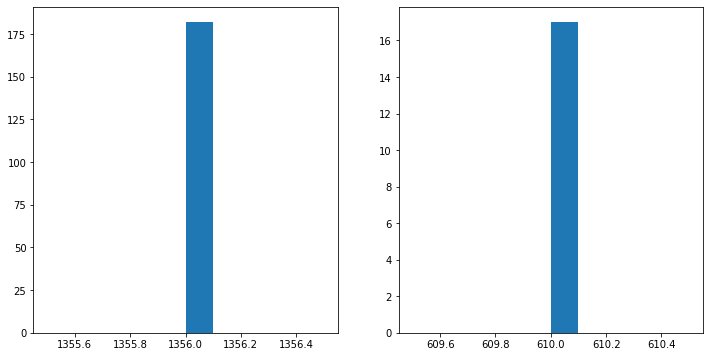

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

train_lens = [len(s) for s in train_sequences_padded]
test_lens = [len(s) for s in test_sequences_padded]

fig, ax = plt.subplots(1,2, figsize=(12, 6))
h1 = ax[0].hist(train_lens)
h2 = ax[1].hist(test_lens)

In [ ]:
# while 250 is long should be a safe bet
MAX_SEQUENCE_LENGTH = 1400

In [ ]:
# pad dataset to a maximum review length in words
X_train = sequence.pad_sequences(train_sequences_padded, maxlen=MAX_SEQUENCE_LENGTH)
X_test = sequence.pad_sequences(test_sequences_padded, maxlen=MAX_SEQUENCE_LENGTH)
X_train.shape, X_test.shape

((182, 1400), (17, 1400))

In [ ]:
le = LabelEncoder()
# positive -> 1, negative -> 0
num_classes=2 

In [ ]:
def return_y_vector(input_sequence,lead_sequence)

In [ ]:
y_train2 = np.array(y_train)
y_test2 = np.array(y_test)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  


In [ ]:
nparrs = []
for arr in y_train2:
  nparr = np.array(arr).astype("float32")
  nparrs.append(nparr)
y_train3 = np.array(nparrs)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  """


In [ ]:
VOCAB_SIZE = len(t.word_index)

In [ ]:
EMBED_SIZE = 300
EPOCHS = 10
BATCH_SIZE = 128

model = Sequential()
model.add(Embedding(VOCAB_SIZE,EMBED_SIZE,input_length=MAX_SEQUENCE_LENGTH))

model.add(Conv1D(filters=128,kernel_size=4,activation='relu',padding='same'))
model.add(MaxPooling1D(pool_size=2))

model.add(Conv1D(filters=64,kernel_size=4,activation='relu',padding='same'))
model.add(MaxPooling1D(pool_size=2))

model.add(Conv1D(filters=32,kernel_size=4,activation='relu',padding='same'))
model.add(MaxPooling1D(pool_size=2))

model.add(Flatten())

model.add(Dense(256,activation='relu'))
model.add(Dense(1,activation='sigmoid'))

model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 1400, 300)         1308900   
                                                                 
 conv1d_3 (Conv1D)           (None, 1400, 128)         153728    
                                                                 
 max_pooling1d_3 (MaxPooling  (None, 700, 128)         0         
 1D)                                                             
                                                                 
 conv1d_4 (Conv1D)           (None, 700, 64)           32832     
                                                                 
 max_pooling1d_4 (MaxPooling  (None, 350, 64)          0         
 1D)                                                             
                                                                 
 conv1d_5 (Conv1D)           (None, 350, 32)          

In [ ]:
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=2,restore_best_weights=True,verbose=1)

In [ ]:
# X_train,y_train

In [ ]:
X_train = np.array(train_sequences_padded)

In [ ]:
nparrs = []
for item in train_sequences_padded:
  nparr = np.array(item).astype("float32")
  nparrs.append(nparr)

In [ ]:
result_X = np.array(nparrs).astype("float32")

In [ ]:
result_X.shape

(182, 1356)

In [ ]:
model.fit(result_X,y_train3,validation_split=0.1,epochs=EPOCHS,batch_size=BATCH_SIZE,callbacks=[es],verbose=1)

ValueError: ignored

In [ ]:
# https://www.tensorflow.org/guide/keras/rnn#built-in_rnn_layers_a_simple_example
# Looks like I have to normalize the essay length and discourse length!
model = keras.Sequential()
# Add an Embedding layer expecting input vocab of size 1000, and
# output embedding dimension of size 64.
model.add(layers.Embedding(input_dim=1000, output_dim=64))

# Add a LSTM layer with 128 internal units.
model.add(layers.LSTM(128))

# Add a Dense layer with 10 units.
model.add(layers.Dense(10))

model.summary()